In [2]:
import os
import numpy as np
import scipy as sp
from scipy.linalg import expm
import pandas as pandas
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from Nexis_functions import heatmap, total_tau_plot, normalize_by_l2_norm, mse_matrix
from functools import partial
from Nexis_model_seedop import run_Nexis
from scipy.stats import pearsonr
import seaborn as sns
import heapq
from matplotlib.colors import LinearSegmentedColormap



## Preparing Inputs

In [3]:
# Prepare connectivity matrix

# Load connectivity matrix
connectivity_df = pandas.read_csv('Connectivity matrix.csv')

# List of striatal regions to exclude from further analysis 
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Find indices (in the region order of the connectivity matrix) for regions to exclude 
excluded_indices = [connectivity_df.columns.get_loc(region) for region in regions_to_exclude]

# Delete striatal regions 
connectivity_df = connectivity_df.drop(index = excluded_indices)
connectivity_df = connectivity_df.drop(columns=regions_to_exclude)

# Convert connectivity matrix to a nROI x nROI array
connectivity_matrix = connectivity_df.values

# Normalize connectivity matrix (divide by max because min is already 0 in diagonal entries)
max = np.max(connectivity_matrix)
connectivity_matrix = connectivity_matrix / max

In [4]:
# Load DK regional volumes 
regional_volumes = pandas.read_csv('DK_ROI_volumes.csv')

# Convert to an 1 x nROI array 
regional_volumes = regional_volumes.values

# Converting region order of DK to that of connectivity matrix
new_order_DK = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]
regional_volumes_reordered = regional_volumes[new_order_DK, :]

# Delete striatal regions
regional_volumes_excluded = np.delete(regional_volumes_reordered,excluded_indices)

# Define the number of regions  
nROI = 86 - len(regions_to_exclude)

# Order of regions (left subcortex, right subcortex, left cortex, right cortex)
regions = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula', 'ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',	'ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']

In [5]:
# Run on either individual subjects (1) or whole cohort (0) (SET HERE)
individual = 1

In [6]:
# Define inputs to NEXIS

C_ = connectivity_matrix  # Connectivity matrix (nROI x nROI)
U_ = np.zeros((nROI, 1)) # Cell type matrix (nROI x nTypes)/ gene_data_reordered
if individual == 1:
    t_vec_ = np.linspace(0, 18, 19)
else:
    t_vec_ = np.linspace(0, 10, 100)  # Time vector (include 100 time points) (1 x nt)
w_dir_ = 0  # Since I don't care about directionality, set to 0 which overwrites s as 0.5
volcorrect_ = 1  # Binary flag set to 0 if not correcting for volume, set to 1 if correcting for volume and add regional volume data to regional_volumes
region_volumes_ = regional_volumes_excluded  # Regional volumes for normalization (nROI x 1)
logistic_term_ = 0 # Binary flag set to 1 to run with logistic term and 0 to run without

## Load Patient Data

In [7]:
# Load and organize longitudinal data

longitudinal_stage_tau = pandas.read_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/sustaln/SuStaIn/stage and tau/longitudinal_stage_tau.csv')
columns_to_move = ['EXAMDATE', 'DX', 'time_elapsed', 'ml_stage']
other_columns = [col for col in longitudinal_stage_tau.columns if col not in columns_to_move]
new_column_order = columns_to_move + other_columns
longitudinal_stage_tau = longitudinal_stage_tau[new_column_order]
longitudinal_stage_tau = longitudinal_stage_tau.drop('Unnamed: 0', axis=1)
longitudinal_stage_tau = longitudinal_stage_tau.drop('ctx-rh-bankssts.1', axis=1)

# List of striatal regions to exclude from further analysis due to errors in tau-PET imaging (CAN EDIT THIS)
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Conversion of ADNI region order to match connectivity matrix
ADNI_to_norm = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]

# Order of regions (left subcortex, right subcortex, left cortex, right cortex)
regions = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula', 'ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',	'ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']

#  Delete striatal regions 
longitudinal_stage_tau = longitudinal_stage_tau.drop(regions_to_exclude, axis = 1)

# Reorder regions 
reordered_df = longitudinal_stage_tau.iloc[:, :5]  
region_columns = [col for col in regions if col in longitudinal_stage_tau.columns]
reordered_df = pandas.concat([reordered_df, longitudinal_stage_tau[region_columns]], axis=1)
longitudinal_stage_tau = reordered_df

# Keep on dementia subjects with longitudinal data
dementia_rids = longitudinal_stage_tau[longitudinal_stage_tau['DX'] == 'Dementia']['RID'].unique()

# Filter out RIDs with NaN in ml_stage column 
longitudinal_stage_tau_dementia = longitudinal_stage_tau[
    #(longitudinal_stage_tau['RID'].isin(dementia_rids)) &
    (longitudinal_stage_tau['ml_stage'].notna())
]
# Calculate total tau
longitudinal_stage_tau_dementia['tau_sum'] = longitudinal_stage_tau_dementia.iloc[:, 5:].sum(axis=1)
columns = longitudinal_stage_tau_dementia.columns.tolist()
columns.insert(4, columns.pop(columns.index('tau_sum')))
longitudinal_stage_tau_dementia = longitudinal_stage_tau_dementia[columns]

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_26995/2462682234.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longitudinal_stage_tau_dementia['tau_sum'] = longitudinal_stage_tau_dementia.iloc[:, 5:].sum(axis=1)


In [18]:
# Upload patient data
patient_data = pandas.read_csv('EBM stage + tau/Stage + tau - version 9 final run.csv')
# with tmax: Cross-sectional stage and regional tau - version 9.csv (old final)
# without tmax: Stage + tau - version 9 final run (FINAL)

# Avoid repeating any RIDS and remove controls
unique_rids = patient_data['RID'].unique()

demo = patient_data.columns[:4]
tau = patient_data.columns[4:]

# Reorder regions to match region order of connectivity matrix
new_order_ADNI = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
reordered_columns = tau[new_order_ADNI]
new_column_order = list(demo) + list(reordered_columns)
patient_data = patient_data[new_column_order]

# Delete striatal regions 
patient_data = patient_data.drop(regions_to_exclude, axis = 1)

if individual:
    RID = 6483 #EDIT PATIENT RID MANUALLY HERE (individual seeds figure: 4637, 2373) (longitudinal validation: 6284, 4197)
    patient = patient_data[patient_data['RID'] == RID] 
    patient_longitudinal = longitudinal_stage_tau[longitudinal_stage_tau['RID'] == RID]

    # Define number of time points 
    num_time_points = patient.shape[0]
    num_time_points_longitudinal = patient_longitudinal.shape[0]

    # Define list with stage assingments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]
    # LATER: DEFINE IN TERMS OF TIME WHERE TIME vs. STAGE RELAITONSHIP IS SIGNMOIDAL

    # Define patient tau data
    patient_tau = patient.iloc[:,4:]

    # Convert to array and transpose so dim = nROI x # of stages
    patient_tau = patient_tau.to_numpy()
    patient_tau = patient_tau.T 

    # If subject had longitudinal data, repeat for longitudinal data
    if num_time_points_longitudinal > 1:
        # Delete baseline 
        patient_longitudinal = patient_longitudinal.iloc[1:]
        stages_longitudinal = patient_longitudinal['ml_stage'].tolist()
        stages_longitudinal = [int(x) for x in stages_longitudinal]
        patient_tau_longitudinal = patient_longitudinal.iloc[:,5:]
        patient_tau_longitudinal = patient_tau_longitudinal.to_numpy()
        patient_tau_longitudinal = patient_tau_longitudinal.T


else: 

    # Upload EBM time series
    EBM_data = pandas.read_csv('EBM time series/EBM time series - version 9 final run.csv')
    # with tmax: EBM time series - version 9.csv (old final)
    # without tmax: EBM time series - version 9 final run.csv (FINAL)
    EBM_data = EBM_data.drop('Unnamed: 0', axis=1)

    # Normalize by mean at t=0
    t0_mean = EBM_data.iloc[0].mean()
    EBM_data = EBM_data / t0_mean
    EBM_data = EBM_data / 10

    # Reorder regions to match region order of connectivity matrix
    EBM_data_reordered = EBM_data.iloc[:, new_order_ADNI]

    # Delete striatal regions 
    columns_to_delete = EBM_data_reordered.columns[excluded_indices]
    EBM_data_excluded = EBM_data_reordered.drop(columns_to_delete, axis = 1)

     # Convert to an nROI x 100 array and transpose
    EBM_data_array = EBM_data_excluded.values
    EBM_data_transposed = EBM_data_array.T

## Seed Optimization

In [9]:
# Determining optimal lambda
nexis_model = run_Nexis(C_=C_, U_=U_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_,
                        region_volumes_=region_volumes_, logistic_term_=1)

# Create data from for lambda and MSE
column_names_1 = ['L1 cost', 'error','MSE', 'Lambda', 'optimized initial vector']
L1_mse = pandas.DataFrame(columns = column_names_1)

for Lambda in np.arange(0, 0.06, 0.005):

        # Define a function that runs Nexis and calculates the MSE 
        def Nexis_MSE(params, patient_tau):
                
                param1 = params # param1 = initial vector

                # Initialize run_Nexis class 
                nexis_model_mse = run_Nexis(C_=C_, U_=U_, t_vec_=t_vec_, w_dir_=w_dir_,
                                volcorrect_=volcorrect_, region_volumes_=region_volumes_, logistic_term_=1)

                # Parameters for simulate_nexis method
                parameters = [0.17246100, 0.1195576246, 1.0, 0.5, 0.0, 0.0, 50.0, param1]  # [alpha, beta, gamma, s, b, p , k, inital vector] 

                # Call the simulate_nexis method with the parameters
                Y = nexis_model_mse.simulate_nexis(parameters)

                # For optimization, only take stages from Y that correspond to patient's stages 
                if individual:
                        Y_edited = Y[:, stages] 

                        # Check for constant input arrays
                        if np.all(patient_tau == patient_tau[0]) or np.all(Y_edited == Y_edited[0]):
                                return 1e10
                
                        # Calculate R
                        corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
                        error = mse_matrix(patient_tau,Y_edited) + 0.5 * (1- corr_coeff) + Lambda * param1.sum() 

                else:

                        # Check if Y is constant
                        if np.all(Y == Y[0]):
                                Y[0] = Y[0] + 0.00001 # Add small constant 

                        # Fit to EBM interpolation
                        corr_coeff, p_value = pearsonr(EBM_data_transposed.flatten(), Y.flatten())
                        error = mse_matrix(EBM_data_transposed, Y) + 0.5 * (1- corr_coeff) + Lambda * (param1.sum())
                
                return error

        #Optimize parameters by minimizing MSE between patient data and Y
        custom_Nexis_MSE = partial(Nexis_MSE, patient_tau=patient_tau)

        # Initial guesses for initial vector
        seeding_locations = ['ctx-lh-entorhinal', 'ctx-rh-entorhinal'] # Manually edit guess for seeding region here
        seeding_indices = [regions.index(item) for item in seeding_locations if item in seeding_locations]
        array_length = nROI
        init_guess = np.zeros(array_length)
        init_guess[seeding_indices[0]] = 1 
        init_guess[seeding_indices[1]] = 1

        # Bounds for initial vector
        bounds = [(0, 3) for _ in range(nROI)]

        # Perform the optimization
        result = minimize(custom_Nexis_MSE, init_guess, bounds=bounds, method='L-BFGS-B',
                        options={'ftol': 1e-3, 'gtol': 1e-3,'maxiter': 1000}) 
        
        if result.success:
                optimized_initial_vec = result.x
                #optimized_initial_vec = optimized_initial_vec.tolist()
        
        # Run Nexis    
        parameters =  [0.17246100, 0.1195576246, 1.0, 0.5, 0.0, 0.0, 50.0, optimized_initial_vec] # [alpha, beta, gamma, s, b, p, k, initial vector] # CAN MANUALLY SET PARAMETERS HERE
        Y = nexis_model.simulate_nexis(parameters) 

        if individual:
                Y_edited = Y[:, stages] 
                corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
                mse = mse_matrix(patient_tau,Y_edited)
                error = mse_matrix(patient_tau,Y_edited) + 0.5 * (1- corr_coeff) + Lambda * optimized_initial_vec.sum() / (np.sqrt((sum((optimized_initial_vec)**2))))

        else:
        # Fit to EBM interpolation
                corr_coeff, p_value = pearsonr(EBM_data_transposed.flatten(), Y.flatten())
                mse = mse_matrix(EBM_data_transposed, Y)
                error = mse_matrix(EBM_data_transposed, Y) + 0.5 * (1- corr_coeff) + Lambda * (optimized_initial_vec.sum()) / (np.sqrt((sum((optimized_initial_vec)**2))))        
        
        # Create data frame for lambda value
        sub_df = pandas.DataFrame([[Lambda  * sum(optimized_initial_vec)] + [error] + [mse] + [Lambda] + [optimized_initial_vec]], columns=column_names_1)

        # Concatenate the original DataFrame with the new DataFrame
        L1_mse = pandas.concat([L1_mse, sub_df], ignore_index=True)

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_26995/2928697228.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  L1_mse = pandas.concat([L1_mse, sub_df], ignore_index=True)


In [ ]:
# Plot MSE vs. lambda
L1_mse = L1_mse.sort_values(by='L1 cost')
plt.figure(figsize=(12, 6))
plt.plot(L1_mse['L1 cost'], L1_mse['MSE'], marker='o', linestyle='-', color='k', label='Data Line')

# Add labels and title
plt.xlabel('L1 cost')
plt.ylabel('MSE')
plt.title('MSE vs. L1 cost')

# Show the plot
plt.show()

In [10]:
# SET LAMBDA HERE (for L1 regularization)
Lambda = 0.04 # 0.04 for individual and cohort

# Define cost function
def Nexis_MSE(params, patient_tau, stages):
        
        param1 = params # param1 = initial vector

        # Initialize run_Nexis class 
        nexis_model_mse = run_Nexis(C_=C_, U_=U_, t_vec_=t_vec_, w_dir_=w_dir_,
                            volcorrect_=volcorrect_, region_volumes_=region_volumes_, logistic_term_=1)

        # DEFINE GLOBAL PARAMETERS
        parameters = [0.2117571, 0.170457, 1.0, 0.5, 0.0, 0.0, 50.0, param1]  # [alpha, beta, gamma, s, b, p , k, inital vector] 
        # param op 1: [0.17350, 0.11893]
        # param op 2: [0.19597355713923487, 0.14693994675169672] 
        # param op 3: [0.2117571, 0.170457]

        # Call the simulate_nexis method with the parameters
        Y = nexis_model_mse.simulate_nexis(parameters)

        # For optimization, only take stages from Y that correspond to patient's stages 
        if individual:
                Y_edited = Y[:, stages] 

                # Check for constant input arrays
                if np.all(patient_tau == patient_tau[0]) or np.all(Y_edited == Y_edited[0]):
                        return 1e10
                
                # Calculate R
                corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
                error = mse_matrix(patient_tau,Y_edited) + 0.5 * (1- corr_coeff) + Lambda * param1.sum() / (np.sqrt((sum((param1)**2)))) # version 11
                #error = mse_matrix(patient_tau,Y_edited) + 0.5 * (1- corr_coeff) + Lambda * param1.sum() # version 10


        else:

                # Check if Y is constant
                if np.all(Y == Y[0]):
                        Y[0] = Y[0] + 0.00001 # Add small constant 

                # Fit to EBM interpolation
                corr_coeff, p_value = pearsonr(EBM_data_transposed.flatten(), Y.flatten())
                error = mse_matrix(EBM_data_transposed, Y) + 0.5 * (1- corr_coeff) + Lambda * (param1.sum()) / (np.sqrt((sum((param1)**2)))) # version 11
                #error = mse_matrix(EBM_data_transposed, Y) + 0.5 * (1- corr_coeff) + Lambda * (param1.sum()) # version 10



        return error

In [11]:
if individual:
    custom_Nexis_MSE = partial(Nexis_MSE, patient_tau=patient_tau, stages=stages)
else: 
    custom_Nexis_MSE = partial(Nexis_MSE, patient_tau=patient_tau, stages=0)

# Initial guesses for initial vector
seeding_locations = ['ctx-lh-entorhinal', 'ctx-rh-entorhinal'] # Manually edit guess for seeding region here
seeding_indices = [regions.index(item) for item in seeding_locations if item in seeding_locations]
array_length = nROI
init_guess = np.zeros(array_length)
init_guess[seeding_indices[0]] = 1 
init_guess[seeding_indices[1]] = 1

# Bounds for initial vector
bounds = [(0, 3) for _ in range(nROI)]

# Perform the optimization
result = minimize(custom_Nexis_MSE, init_guess, bounds=bounds, method='L-BFGS-B',
                        options={'ftol': 1e-3, 'gtol': 1e-3,'maxiter': 1000}) 

if result.success:
    optimized_initial_vec = result.x
    optimized_initial_vec = optimized_initial_vec.tolist()

    print(f"Optimization successful. Optimized initial vector: {optimized_initial_vec}")
    print(f"Final error (value of objective function): {result.fun}")
else:
    print("Optimization failed.", result.message)
    print(f"Final error (value of objective function): {result.fun}")
    

Optimization successful. Optimized initial vector: [0.0, 0.08329561633001746, 0.0, 0.010967888898020705, 0.0, 0.0, 0.08550547878531511, 0.01213978670151071, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7828232181132533, 0.0, 0.0, 0.1851751289026186, 0.0, 0.0, 0.09060625152825484, 0.0, 0.01768105904202704, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006358768114213338, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.072970783781205, 0.0, 0.0, 0.21950763861449504, 0.0, 0.0, 0.11461567838122247, 0.0, 0.0183130951692197, 0.0701742934653395, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Final error (value of objective function): 0.16348212066935258


In [ ]:
# TEMP: plotting loss over iterations for an individual

if individual:
    custom_Nexis_MSE = partial(Nexis_MSE, patient_tau=patient_tau, stages=stages)
else:
    custom_Nexis_MSE = partial(Nexis_MSE, patient_tau=patient_tau, stages=0)

error_values = []

def callback(params):
    error = custom_Nexis_MSE(params)  # Remove patient_tau from here
    error_values.append(error)

# Initial guesses for initial vector
seeding_locations = ['ctx-lh-entorhinal', 'ctx-rh-entorhinal']  # Manually edit guess for seeding region here
seeding_indices = [regions.index(item) for item in seeding_locations if item in regions]
array_length = nROI
init_guess = np.zeros(array_length)
init_guess[seeding_indices[0]] = 1
init_guess[seeding_indices[1]] = 1

# Bounds for initial vector
bounds = [(0, 3) for _ in range(nROI)]

# Perform the optimization
result = minimize(custom_Nexis_MSE, init_guess, bounds=bounds, method='L-BFGS-B',
                  options={'ftol': 1e-3, 'gtol': 1e-3, 'disp': True, 'maxiter': 1000}, callback=callback)

if result.success:
    optimized_initial_vec = result.x.tolist()
    print(f"Optimization successful. Optimized initial vector: {optimized_initial_vec}")
    print(f"Final error (value of objective function): {result.fun}")
else:
    print("Optimization failed.", result.message)
    print(f"Final error (value of objective function): {result.fun}")

# Plot error values across iterations
plt.figure(figsize=(9, 11))
plt.plot(range(len(error_values)), error_values, marker='o', linestyle='-', linewidth=3, color='#6B8E23')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error Value Across Iterations')
plt.show()

In [ ]:
# Threshold regional seed values to increase sparcity
num_seeds = 6 # SET HERE number of highest tau regions retained
thresholded_init_vec = optimized_initial_vec.copy()
top_values = heapq.nlargest(num_seeds, thresholded_init_vec)
thresholded_init_vec = [x if x in top_values else 0 for x in thresholded_init_vec]

# Create a heatmap of initial vector
blue_cmap = LinearSegmentedColormap.from_list("custom_blue", ["#E0FFFF", "#87CEFA", "#4682B4", "#00008B"])
plt.figure(figsize=(8, 2)) 
sns.heatmap([optimized_initial_vec], cmap= blue_cmap, vmax= 0.3)
# Add labels and title
plt.xlabel('Regions')
plt.title('Initial vector')

# Print highest tau seed regions
top_seed_values = sorted(optimized_initial_vec, reverse=True)[:5]
top_indices = sorted(range(len(optimized_initial_vec)), key=lambda i: optimized_initial_vec[i], reverse=True)[:5]
regions_array = np.array(regions)
top_seeds = regions_array[top_indices]
print('Top seed regions: ' + str(top_seeds))

def energy_calc(seed): 
    seed = np.array(seed)
    seed_ordered = np.sort(seed)[::-1]
    seed_sum = seed.sum()
    percent_of_sum = seed_sum * 0.9

    temp_sum = 0
    for value in seed_ordered:
        temp_sum = temp_sum + value
        if temp_sum > percent_of_sum:
            threshold = value
            print('Threshold: ' + str(threshold))
            count_sparse_regions = np.sum(seed > threshold)
            print('Regions above threshold (regions that contribute to 90% of total seed energy): ' + str(count_sparse_regions))
            return
        
energy_calc(optimized_initial_vec)

## Running Nexis

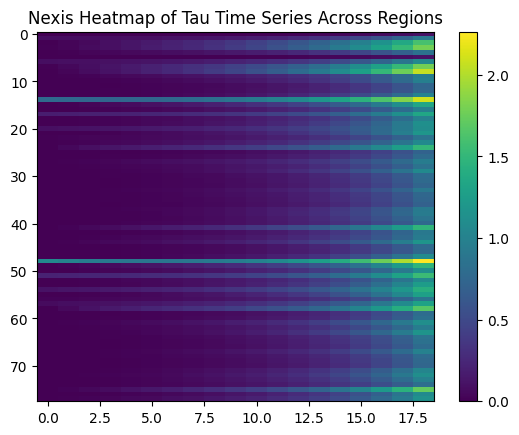

In [12]:
# Initialize run_Nexis class 
nexis_model = run_Nexis(C_=C_, U_=U_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_,
                        region_volumes_=region_volumes_, logistic_term_=1)

# Parameters for simulate_nexis method
parameters =  [0.2117571, 0.170457, 1, 0.5, 0.0, 0.0, 50.0, optimized_initial_vec] # [alpha, beta, gamma, s, b, p, k, initial vector] # CAN MANUALLY SET PARAMETERS HERE

# Call the simulate_nexis method with the parameters
Y = nexis_model.simulate_nexis(parameters)

if individual:  
    # Take stages from Y that correspond to patient's stages 
    Y_edited = Y[:, stages]

# Plot heatmap of Y
plt = heatmap('baseline',Y)

In [28]:
# Save cohort-level eNDM fit for pysurfer visualization
Y_T = Y.T
Y_df = pandas.DataFrame(Y_T, columns=regions)
Y_df.to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/Pysurfer data/Final cohort-level eNDM fit.csv')

## Check Results

In [13]:
if individual:
    # Calculate MSE and R for baseline
    mse_baseline = mse_matrix(patient_tau, Y_edited)
    print('Mean squared error baseline: ' + str(mse_baseline))
    R_baseline, p_value = pearsonr(Y_edited.flatten(), patient_tau.flatten())
    print('Pearsons R baseline: ' + str(R_baseline))

    # MSE and R for longitudinal
    Y_edited_longitudinal = Y[:, stages_longitudinal[:2]]
    mse_longitudinal = mse_matrix(patient_tau_longitudinal[:,:2], Y_edited_longitudinal)
    print('Mean squared error longitudinal: ' + str(mse_longitudinal))
    R_longitudinal, p_value_longitudinal = pearsonr(patient_tau_longitudinal[:,:2].flatten(), Y_edited_longitudinal.flatten())
    print('Pearsons R longitudinal: ' + str(R_longitudinal))


Mean squared error baseline: 0.012142548144654593
Pearsons R baseline: 0.8582716432022622


NameError: name 'stages_longitudinal' is not defined

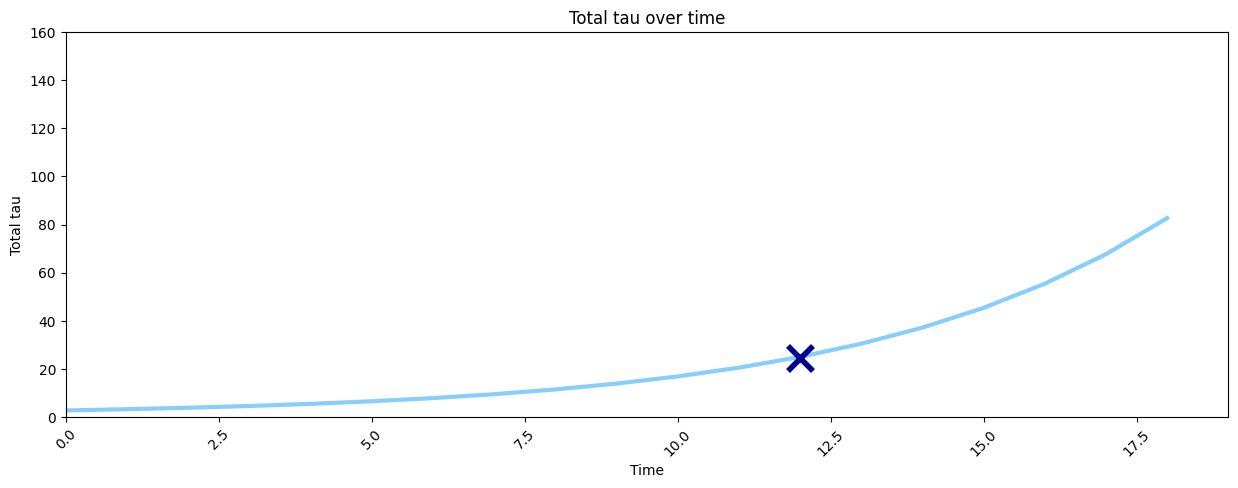

In [14]:
# Plot total tau over time for patient tau and Y_edited

# Do you want to plot longitudinal validation or just baseline?
longitudinal = 0

if individual:

    # Volume correction
    #regional_volumes_array = np.array(regional_volumes_excluded)
    #regional_volumes_array = regional_volumes_array.reshape((78,1))
    #tau_mass_Y = regional_volumes_array * Y
    #total_tau_Y = np.sum(tau_mass_Y, axis=0)
    total_tau_Y = np.sum(Y, axis=0)

    patient_tau = patient_tau.reshape(78,1)
    #tau_mass_patient = regional_volumes_array * patient_tau
    #total_tau_patient = np.sum(tau_mass_patient, axis=0)
    total_tau_patient = np.sum(patient_tau, axis=0)
    if longitudinal:
        longitudinal_sums = patient_tau_longitudinal.sum(axis=0)
    
    time_points_Y = np.linspace(0, 18, 19)

    plt.figure(figsize=(15, 5))

    # Plot total_tau_Y
    plt.plot(time_points_Y, total_tau_Y, linestyle='-', linewidth = 3, color='#87CEFA', label= 'Y') 

    # Plot total_tau_patient (baseline and longitudinal) on the same graph
    plt.plot(stages, total_tau_patient, marker='x', linestyle='--', color='#00008B', label= 'patient', markersize=18, markeredgewidth=4)
    #for i in range(len(longitudinal_sums)-1):
        #plt.plot(stages_longitudinal[i], longitudinal_sums[i], marker='x', linestyle='--', color= 'red', label= 'patient', markersize=18, markeredgewidth=4)
    
    plt.title('Total tau over time') 
    plt.xlabel('Time')  # Label the x-axis
    plt.ylabel('Total tau')  # Label the y-axis
    plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
    plt.xlim(0,19)
    plt.ylim(0,160)
    #plt.legend()  # Add a legend to distinguish the two lines
    plt.show

else:
    # Define time points 
    time_points = np.linspace(0,18,19)

    plt.figure(figsize=(10, 6))

    # Plot Y
    total_tau_Y = np.sum(Y, axis=0)
    plt.plot(time_points, total_tau_Y, marker='o', linestyle='-', color='r', label= 'Y')  

    # Plot total tau for each subject
    patient_data.loc[:, 'Sum'] = patient_data.iloc[:, 4:].sum(axis=1)
    plt.scatter(patient_data['ml_stage'], patient_data['Sum'], color='b', label='Subjects')

    plt.title('Total tau over time') 
    plt.xlabel('Time')  # Label the x-axis
    plt.ylabel('Total tau')  # Label the y-axis
    plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
    #plt.legend()  # Add a legend to distinguish the two lines
    plt.show

In [228]:
# Saving Y and patient tau to be displayed by PySurfer
Y_trans = Y.T
Y_df = pandas.DataFrame(Y_trans, columns = regions)
Y_df.to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/Pysurfer data/4197 seed op.csv')

if num_time_points_longitudinal > 1:
    patient_tau_combined = np.concatenate((patient_tau, patient_tau_longitudinal), axis=1)
    patient_tau_combined_trans = patient_tau_combined.T
    patient_tau_combined_df = pandas.DataFrame(patient_tau_combined_trans, columns = regions)
    patient_tau_combined_df.to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/Pysurfer data/4197 raw tau.csv')

else:
    patient_tau_trans = patient_tau.T
    patient_tau_df = pandas.DataFrame(patient_tau_trans, columns = regions)
    patient_tau_df.to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/Pysurfer data/4197 raw tau.csv')

## Loop through all subjects

In [15]:
# Create a data frame for all patients seeding patterns
column_names = ['RID', 'MSE', 'R', 'MSE_longitudinal', 'R_longitudinal','Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate',	'ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal',	'ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula','ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus','ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']
seeding_all = pandas.DataFrame(columns=column_names)

# Create dictionary for entire time series for each subject
timeseries_all_dict = {}

for rid in unique_rids:

    patient = patient_data[patient_data['RID'] == rid] 
    patient_longitudinal = longitudinal_stage_tau[longitudinal_stage_tau['RID'] == rid]

    # Define number of time points 
    num_time_points = patient.shape[0]
    num_time_points_longitudinal = patient_longitudinal.shape[0]

    # Define list with stage assingments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]

    # Define patient tau data
    patient_tau = patient.iloc[:,4:]

    # Convert to array and transpose so dim = nROI x # of stages
    patient_tau = patient_tau.to_numpy()
    patient_tau = patient_tau.T

    # If subject had longitudinal data, repeat for longitudinal data
    if num_time_points_longitudinal > 1:
        # Delete baseline 
        patient_longitudinal = patient_longitudinal.iloc[1:]
        stages_longitudinal = patient_longitudinal['ml_stage'].tolist()
        stages_longitudinal = [int(x) for x in stages_longitudinal]
        tau_longitudinal = patient_longitudinal.iloc[:,5:]
        tau_longitudinal = tau_longitudinal.to_numpy()
        tau_longitudinal = tau_longitudinal.T

    # Perform the optimization
    custom_Nexis_MSE = partial(Nexis_MSE, patient_tau=patient_tau, stages=stages)

    result = minimize(custom_Nexis_MSE, init_guess, bounds=bounds, method='L-BFGS-B', 
                    options={'ftol': 1e-3, 'gtol': 1e-3, 'maxiter': 1000})
    
    if result.success:
        optimized_initial_vec = result.x
        optimized_initial_vec = optimized_initial_vec.tolist( )

    # Run Nexis    
    parameters =  [0.2117571, 0.170457, 1, 0.5, 0.0, 0.0, 50.0, optimized_initial_vec] # [alpha, beta, gamma, s, b, p, k, initial vector] # CAN MANUALLY SET PARAMETERS HERE
    Y = nexis_model.simulate_nexis(parameters) 
    Y_edited = Y[:, stages]
    
    # Calculate MSE and R
    mse = mse_matrix(patient_tau, Y_edited)
    corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())

    if num_time_points_longitudinal > 1:
        Y_edited_longitudinal = Y[:, stages_longitudinal]
        mse_longitudinal = mse_matrix(tau_longitudinal, Y_edited_longitudinal)
        corr_coeff_longitudinal, p_value_longitudinal = pearsonr(tau_longitudinal.flatten(), Y_edited_longitudinal.flatten())

    # Create data frame for the subject (seeding and time series)
    if num_time_points_longitudinal > 1:
        seeding = pandas.DataFrame([[rid] + [mse] + [corr_coeff] + [mse_longitudinal] + [corr_coeff_longitudinal] + optimized_initial_vec], columns=column_names)
    else:
        seeding = pandas.DataFrame([[rid] + [mse] + [corr_coeff] + ['NaN'] + ['NaN'] + optimized_initial_vec], columns=column_names)
    timeseries = pandas.DataFrame(Y)

    # Concatenate the original DataFrame with the new DataFrame
    seeding_all = pandas.concat([seeding_all, seeding], ignore_index=True)
    # Add timeseries DataFrame to timeseries_all_dict with RID as the key
    timeseries_all_dict[rid] = timeseries

seeding_all

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_26995/2189707999.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  seeding_all = pandas.concat([seeding_all, seeding], ignore_index=True)


,RID,MSE,R,MSE_longitudinal,R_longitudinal,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Hippocampus,Left-Amygdala,Left-VentralDC,...,ctx-rh-rostralanteriorcingulate,ctx-rh-rostralmiddlefrontal,ctx-rh-superiorfrontal,ctx-rh-superiorparietal,ctx-rh-superiortemporal,ctx-rh-supramarginal,ctx-rh-frontalpole,ctx-rh-temporalpole,ctx-rh-transversetemporal,ctx-rh-insula
0,21,0.007740,0.878801,NaN,NaN,0.000000,0.384470,0.752585,0.095794,0.308682,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.154798,0.0,0.000000
1,31,0.002828,0.886580,0.004577,0.848799,0.000000,0.098712,0.297025,0.124088,0.215568,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.236679,0.0,0.000000
2,56,0.010517,0.896736,0.012666,0.842576,0.000000,0.535736,0.459687,0.249475,0.511742,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.136647,0.0,0.027849
3,59,0.008492,0.861284,NaN,NaN,0.000000,0.319444,0.644882,0.128832,0.349588,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,69,0.006275,0.860004,0.00376,0.904679,0.000000,0.300522,0.153533,0.304119,0.249791,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.048246,0.0,0.155292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,6704,0.006262,0.855981,NaN,NaN,0.000000,0.172360,0.140588,0.162241,0.547902,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
646,6705,0.011254,0.768282,NaN,NaN,0.012763,0.152546,0.000000,0.056130,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
647,6713,0.005076,0.930074,NaN,NaN,0.000000,0.000000,0.394543,0.723147,0.105473,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.198561,0.0,0.000000
648,6721,0.004914,0.857509,NaN,NaN,0.000000,0.289240,0.266622,0.176561,0.386124,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.095618


In [17]:
# Add diagnosis and ml_stage information to data frame
seeding_all.insert(1, 'Diagnosis', patient_data['Diagnosis'])
#seeding_all.insert(2, 'ml_stage', patient_data['ml_stage'])

# Save data frame with seeds, R, and MSE to a csv 
seeding_all.to_csv('seed vs. param op/Optimized seed - version 9 - divided by sqr(L2), lambda = 0.04 2.csv')

In [16]:
# Save dictionary with timeseries for each subject
import pickle
with open('seed vs. param op/timeseries_all_dict.pkl', 'wb') as f:
    pickle.dump(timeseries_all_dict, f)

In [ ]:
# Creat violin plots of pairwise correlations across all subjects for each stage

# Initialize a new dictionary to store data by stage
stages_dict = {}

# Iterate through each stage
for stage in range(19):
    stage_data = []
    subject_ids = []
    
    # Iterate through each subject in the original dictionary
    for subject_id, subject_df in timeseries_all_dict.items():
        stage_data.append(subject_df.iloc[:, stage])
        subject_ids.append(subject_id)
    
    # Create a DataFrame for this stage
    if stage_data:
        stage_df = pandas.DataFrame(stage_data, index=subject_ids, columns=subject_df.index)
        stages_dict[str(stage)] = stage_df

# Create violin plots of pairwise R correlations for each stage
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(20, 10))

# Prepare data for violin plot
plot_data = []
for stage, data in stages_dict.items():
    # Calculate pairwise correlations for each subject
    corr_matrix = data.T.corr()
    # Extract upper triangle of correlation matrix (excluding diagonal)
    correlations = corr_matrix.values[np.triu_indices_from(corr_matrix, k=1)]
    plot_data.extend([(stage, corr) for corr in correlations])

# Create DataFrame from plot_data
plot_df = pandas.DataFrame(plot_data, columns=['Stage', 'Correlation'])

# Create violin plot
sns.violinplot(x='Stage', y='Correlation', data=plot_df)

plt.title('Distribution of Pairwise R Correlations Across Stages')
plt.xlabel('Stage')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.ylim(-1, 1)  # Set y-axis limits for correlation values
plt.tight_layout()
plt.show()


In [ ]:
# Calculate average tau distribution for each time point 

# Initialize an empty DataFrame to store the average tau distributions
average_tau_distribution = pandas.DataFrame(index=regions)

# Iterate through time points
for t in range(19): 
    # List to store tau distributions for time point t across all subjects
    tau_distributions = []
    
    # Iterate through all subjects 
    for rid in unique_rids:
        # Extract the tau distribution for this time point t for the current subject
        tau_distribution = timeseries_all_dict[rid].iloc[:, t]
        tau_distributions.append(tau_distribution)
    
    # Calculate the average tau distribution for time point t
    if tau_distributions:
        combined = pandas.concat(tau_distributions, axis=1)
        average_tau = combined.mean(axis=1)            
        # Add the average tau distribution to the DataFrame
        average_tau_distribution[f'Time_{t}'] = average_tau.values  # Use .values here
      
    else:
        print(f"No data for time {t}")

average_tau_distribution =average_tau_distribution.T
average_tau_distribution


In [ ]:
# Calculate CV with the improved method for timeseries data
def calculate_cv_biological(variance, means, max_cv=500):
    """
    Calculate CV with handling for biological data
    """
    variance = np.array(variance)
    means = np.array(means)
    abs_means = np.abs(means)
    min_mean_threshold = 1e-6
    
    valid_mask = abs_means > min_mean_threshold
    cv = np.full_like(means, np.nan, dtype=float)
    cv[valid_mask] = np.sqrt(variance[valid_mask]) / abs_means[valid_mask] * 100
    cv = np.clip(cv, 0, max_cv)
    
    return cv

# Initialize lists to store data
all_stages = []
all_cvs = []
all_rids = []

# Calculate CV for each subject and stage
for rid, df in timeseries_all_dict.items():
    # Calculate variance and mean across regions for each stage
    stage_variances = df.var(axis=0)  # variance across regions for each stage
    stage_means = df.mean(axis=0)     # mean across regions for each stage
    
    # Calculate CV for each stage
    stage_cvs = calculate_cv_biological(stage_variances, stage_means)
    
    # Store data
    stages = list(range(len(stage_cvs)))
    all_stages.extend(stages)
    all_cvs.extend(stage_cvs)
    all_rids.extend([rid] * len(stages))

# Create DataFrame with all data
plot_data = pandas.DataFrame({
    'RID': all_rids,
    'Stage': all_stages,
    'CV': all_cvs
}).dropna()

# Create the plot
plt.figure(figsize=(8, 9))

# Plot individual points
sns.scatterplot(data=plot_data, 
                x='Stage', 
                y='CV', 
                color='#87CEFA', 
                alpha=0.5)

# Calculate and plot CV of CV across stages
cv_of_cv_by_stage = plot_data.groupby('Stage')['CV'].agg(lambda x: np.std(x)/np.mean(x) * 100 if len(x) > 0 and np.mean(x) != 0 else np.nan).reset_index()
cv_of_cv_by_stage = cv_of_cv_by_stage.sort_values('Stage').dropna()

# Plot CV of CV line
plt.plot(cv_of_cv_by_stage['Stage'], 
         cv_of_cv_by_stage['CV'], 
         color='black', 
         linewidth=1, 
         label='CV of CV across subjects')

# Customize plot
plt.title('Coefficient of Variation Across Brain Regions by Stage')
plt.xlabel('Stage')
plt.ylabel('Coefficient of Variation (%)')
plt.ylim(0, 550)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate total tau for each time point
total_tau_average = average_tau_distribution.sum(axis=0)

time_points_Y = np.linspace(0, 18, 19)

plt.figure(figsize=(15, 5))


plt.plot(time_points_Y, total_tau_average, linestyle='-', linewidth = 3, color='#87CEFA', label= 'Average tau distribution')
plt.title('Average Total Tau Over Time')
plt.xlabel('Time')
plt.ylabel('Total Tau')
plt.xticks(rotation=45)
plt.xlim(0, 19)
plt.ylim(0, 160)

plt.tight_layout()
plt.show()


In [113]:
average_tau_distribution.to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/Pysurfer data/average_tau_distribution_across_subjects.csv')

In [49]:
# Save single subject eNDM fit for pysurfer visualization
timeseries_all_dict[6377] = timeseries_all_dict[6377].T
timeseries_all_dict[6377].columns = regions
timeseries_all_dict[6483].to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/visualization/Pysurfer data/6483 seed op.csv')
